# Revised Assignment


In this notebook, we'll walk through the entire pipeline from data loading, preprocessing, training, and validation to testing and plotting the results.

As revised version, based on the feedback provided I make a new folder **scratch** with this notebook as required.

**Note:** The following modules have been implemented from scratch for this project:

- **Modules:**
  - `modules.utils`
  - `modules.networks`
  - `modules.datasets`
  - `modules.data_preprocessor`
  - `modules.visualization`

These modules include custom functions and classes for data processing, model architecture, and visualization.  My primary focus was on the following key areas that were initially lacking:
- **Data Processing:** Custom functions were added to preprocess and handle the ECG data effectively.
- **Model Training, Validation, and Testing:** The entire training and evaluation pipeline is built from scratch, providing flexibility and control over the process.
- **Grad-CAM Integration:** An explanation of the results is included using Grad-CAM to visualize the model’s focus on different parts of the ECG signal.

---

## Table of Contents

1. **Setup and Imports**
2. **Data Loading**
   1. Displaying Raw Data
3. **Data Preprocessing**
   1. Displaying Processed Data
   2. Data Splits/Distribution
4. **Model Training and Validation**
5. **Testing the ML Model**
6. **Plotting Results**
   1. Confusion Matrix
   2. Losses and Learning Rate
   3. ROC Curve
   4. Precision-Recall Curve
7. **Explaining Results with Grad-CAM**

---

## 1. Setup and Imports

First, let's import the necessary libraries and set up the logging.



In [1]:
import logging
import random
import time
from datetime import datetime
from pathlib import Path
from typing import List, Union
import warnings
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)

# Modules written from scratch
from modules.utils import setup_logging, log_resources, create_dataloaders, preprocess_data
from modules.networks import ResNet
from modules.datasets import ECGDataset
from modules.data_preprocessor import ECGDataPreprocessor 
from modules.visualization import (plot_and_save_individual_confusion_matrices, plot_metrics, plot_roc_curve,
                         plot_precision_recall_curve, plot_roc_curve_per_class, plot_precision_recall_curve_per_class,
                        plot_raw_vs_processed_signals, plot_raw_vs_processed_signals_grid, plot_amplitude_distribution,
                        plot_psd, plot_psd_multichannel,plot_class_distribution, plot_signal_with_annotations, plot_psd_comparison, plot_combined_class_distribution_relative)

# Setup logging
# Setup directory paths
date = datetime.now().strftime('%Y_%m_%d')
time = datetime.now().strftime('%H_%M_%S')
experiment_dir = Path(f"experiments/{date}/{time}")
results_dir = experiment_dir.joinpath("results")
results_dir.mkdir(parents=True, exist_ok=True)

# Setup logging
log_file = "log_training_pipeline.log"
logger = setup_logging(log_file, experiment_dir)

## 2. Data Loading

In this section, we will load the dataset by merging the information of signals and metadata information on CSVs.

The **ECGDataset** class in `modules/datasets.py`  has been implemented to merge these information given the path.


In [2]:
# Define data path and load dataset
data_path = '../../data/ptbxl/'
sampling_rate = 100

# Load dataset
logger.info("Loading data...")
ecg_dataset = ECGDataset(data_dir=Path(data_path), sample_rate=sampling_rate)
raw_data = ecg_dataset.get_raw_data()
logger.info("Data successfully loaded!\n")


2024-08-25 20:35:57,245 - root - INFO - Loading data...
2024-08-25 20:36:51,541 - root - INFO - Data successfully loaded!



### 2.1 Display raw data

- **`plot_signal_with_annotations`**: This function plots the ECG signals for all channels with the diagnostic information as the figure’s title. This allows for easy examination of signal data alongside relevant patient information.

In [3]:
print(raw_data['ecg_signals'][0].shape)
raw_data['ecg_signals'][0]

(1000, 12)


array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [4]:
raw_data['annotations_df'].iloc[0]

patient_id                                                       15709.0
age                                                                 56.0
sex                                                               female
height                                                               NaN
weight                                                              63.0
nurse                                                                2.0
site                                                                 0.0
device                                                         CS-12   E
recording_date                                       1984-11-09 09:17:34
report                            sinusrhythmus periphere niederspannung
scp_codes                       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
heart_axis                                                           NaN
infarction_stadium1                                                  NaN
infarction_stadium2                                

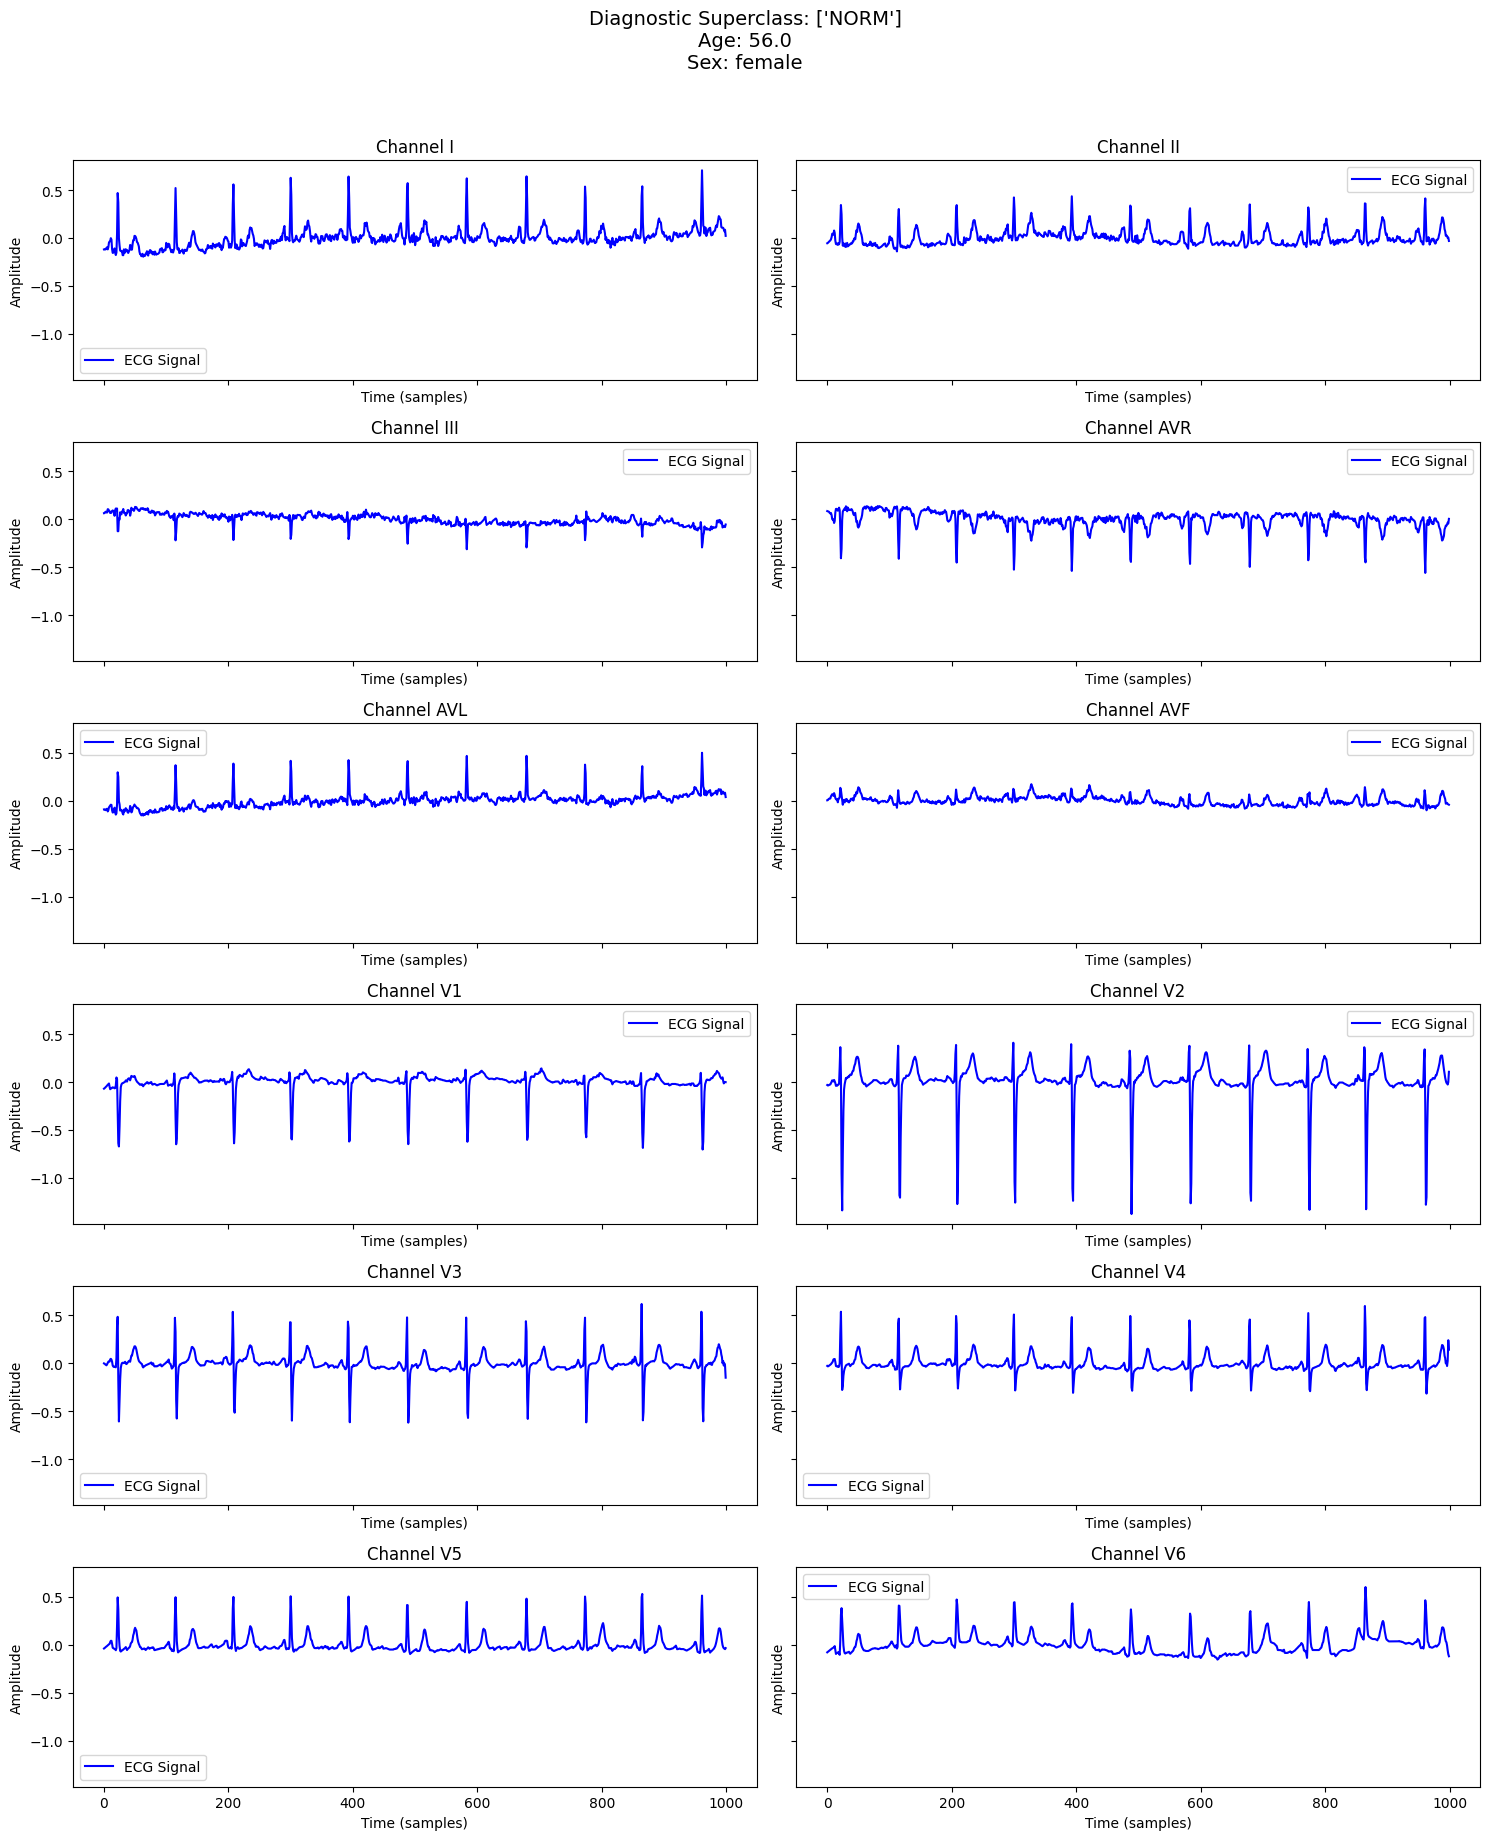

In [5]:
# Display signals (all channels) with annotations and supercalss
raw_signal = raw_data['ecg_signals'][0]
annotation_row = raw_data['annotations_df'].iloc[0]
plot_signal_with_annotations(raw_signal, annotation_row)

## 3. Data Preprocessing

The **ECGDataPreprocessor** class in `modules/data_preprocessor.py`  has been implemented to merge these information given the path.

This preprocessing steps have been implemented:
- **_Normalization_**: standardization or min-max scaling of ECG signals based on provided or computed parameters. **Methods**: _standardize_signal_per_channel_, _minmax_normalize_signal_per_channel_.
- **_Signal Length Standardization_**: Adjusts ECG signal length with zero padding or truncation to a specified segment length.
- **_Denoising_**: applies bandpass filtering and wavelet denoising to remove noise. **Methods**: _bandpass_filter_, _wavelet_denoising_.
- **_Data Augmentation_**: include time warping, amplitude scaling, and adding Gaussian noise. **Methods**: _time_warp_, _amplitude_scaling_, _add_noise_

In [6]:
# Preprocess the data
shuffle = True
normalization_type = 'standardize'#  or 'min-max'
sample_rate = 100
apply_denoising = False # or True
apply_augmentation = False # True

logger.info("Preprocessing data...")
preprocessors, data_info = preprocess_data(
        raw_data=raw_data,
        sample_rate= sample_rate,
        shuffle= shuffle,
        normalization_type = normalization_type,
        segment_length = 0,
        apply_denoising = apply_denoising,
        apply_augmentation= apply_augmentation,
    )

logger.info("Data successfully processed!\n")

# Create dataloaders
logger.info("Splitting data...")
dataloaders = create_dataloaders(preprocessors, batch_size=128)
logger.info("Train, val and test split successfully!\n")


2024-08-25 20:36:52,698 - root - INFO - Preprocessing data...
2024-08-25 20:37:00,721 - root - INFO - Data successfully processed!

2024-08-25 20:37:00,723 - root - INFO - Splitting data...
2024-08-25 20:37:00,725 - root - INFO - Train, val and test split successfully!



### 3.1 Displaying Processed Data
Each function has a specific purpose for analyzing and displaying the ECG data. Here’s an overview of what each function does:

- **`plot_raw_vs_processed_signals`** and **`plot_raw_vs_processed_signals_grid`**: functions to plot the raw ECG signal and its processed version for comparison. Channel-wise and all toghether.


- **`plot_psd`** and **`plot_psd_multichannel`**: function to plot the Power Spectral Density (PSD) of a single ECG signal to analyze the frequency components. Channel-wise and all toghether.

- **`plot_psd_comparison`**: comparing the PSD of raw and processed signals, to see how preprocessing methods have worked (specific frequencies have been attenuated, unwanted noise removed, etc).



In [7]:
# Use few samples od training but without shuffleing to maintain the indexing

normalization_type = 'standardize'
preprocessor = ECGDataPreprocessor( # Extended
    annotations_df=raw_data["annotations_df"].iloc[0:2],
    ecg_signals=raw_data["ecg_signals"][0:2],
    ds_type='train',
    shuffle=False,  # Shuffle only for training
    normalization_type=normalization_type,
    segment_length=0,
    sample_rate=100,
    apply_denoising=False,
    apply_augmentation=False
)

**Visualize a raw vs. processed signal**

In [8]:
raw_signal = raw_data['ecg_signals'][0]
processed_signal = preprocessor.signal_clean[0]
metadata = raw_data['annotations_df'].iloc[0]

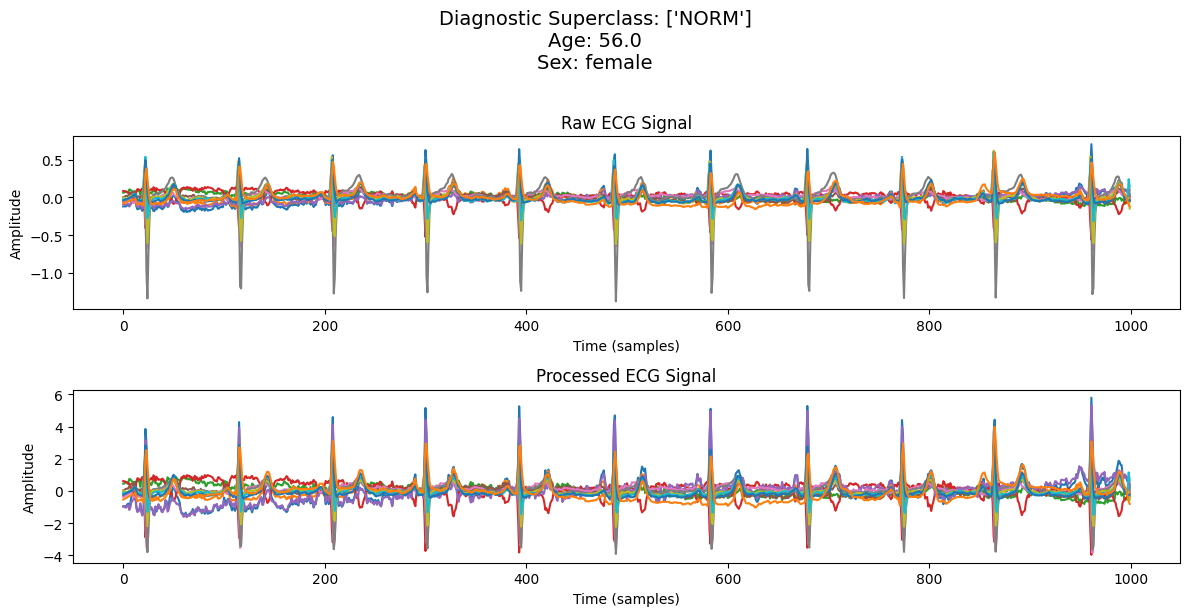

In [9]:
# All channels
plot_raw_vs_processed_signals(raw_signal, processed_signal, metadata )

As we can see the amplitude is rescaled. In the following plots its easier to notice since the processd data have a bigger magnitude due to scalining.

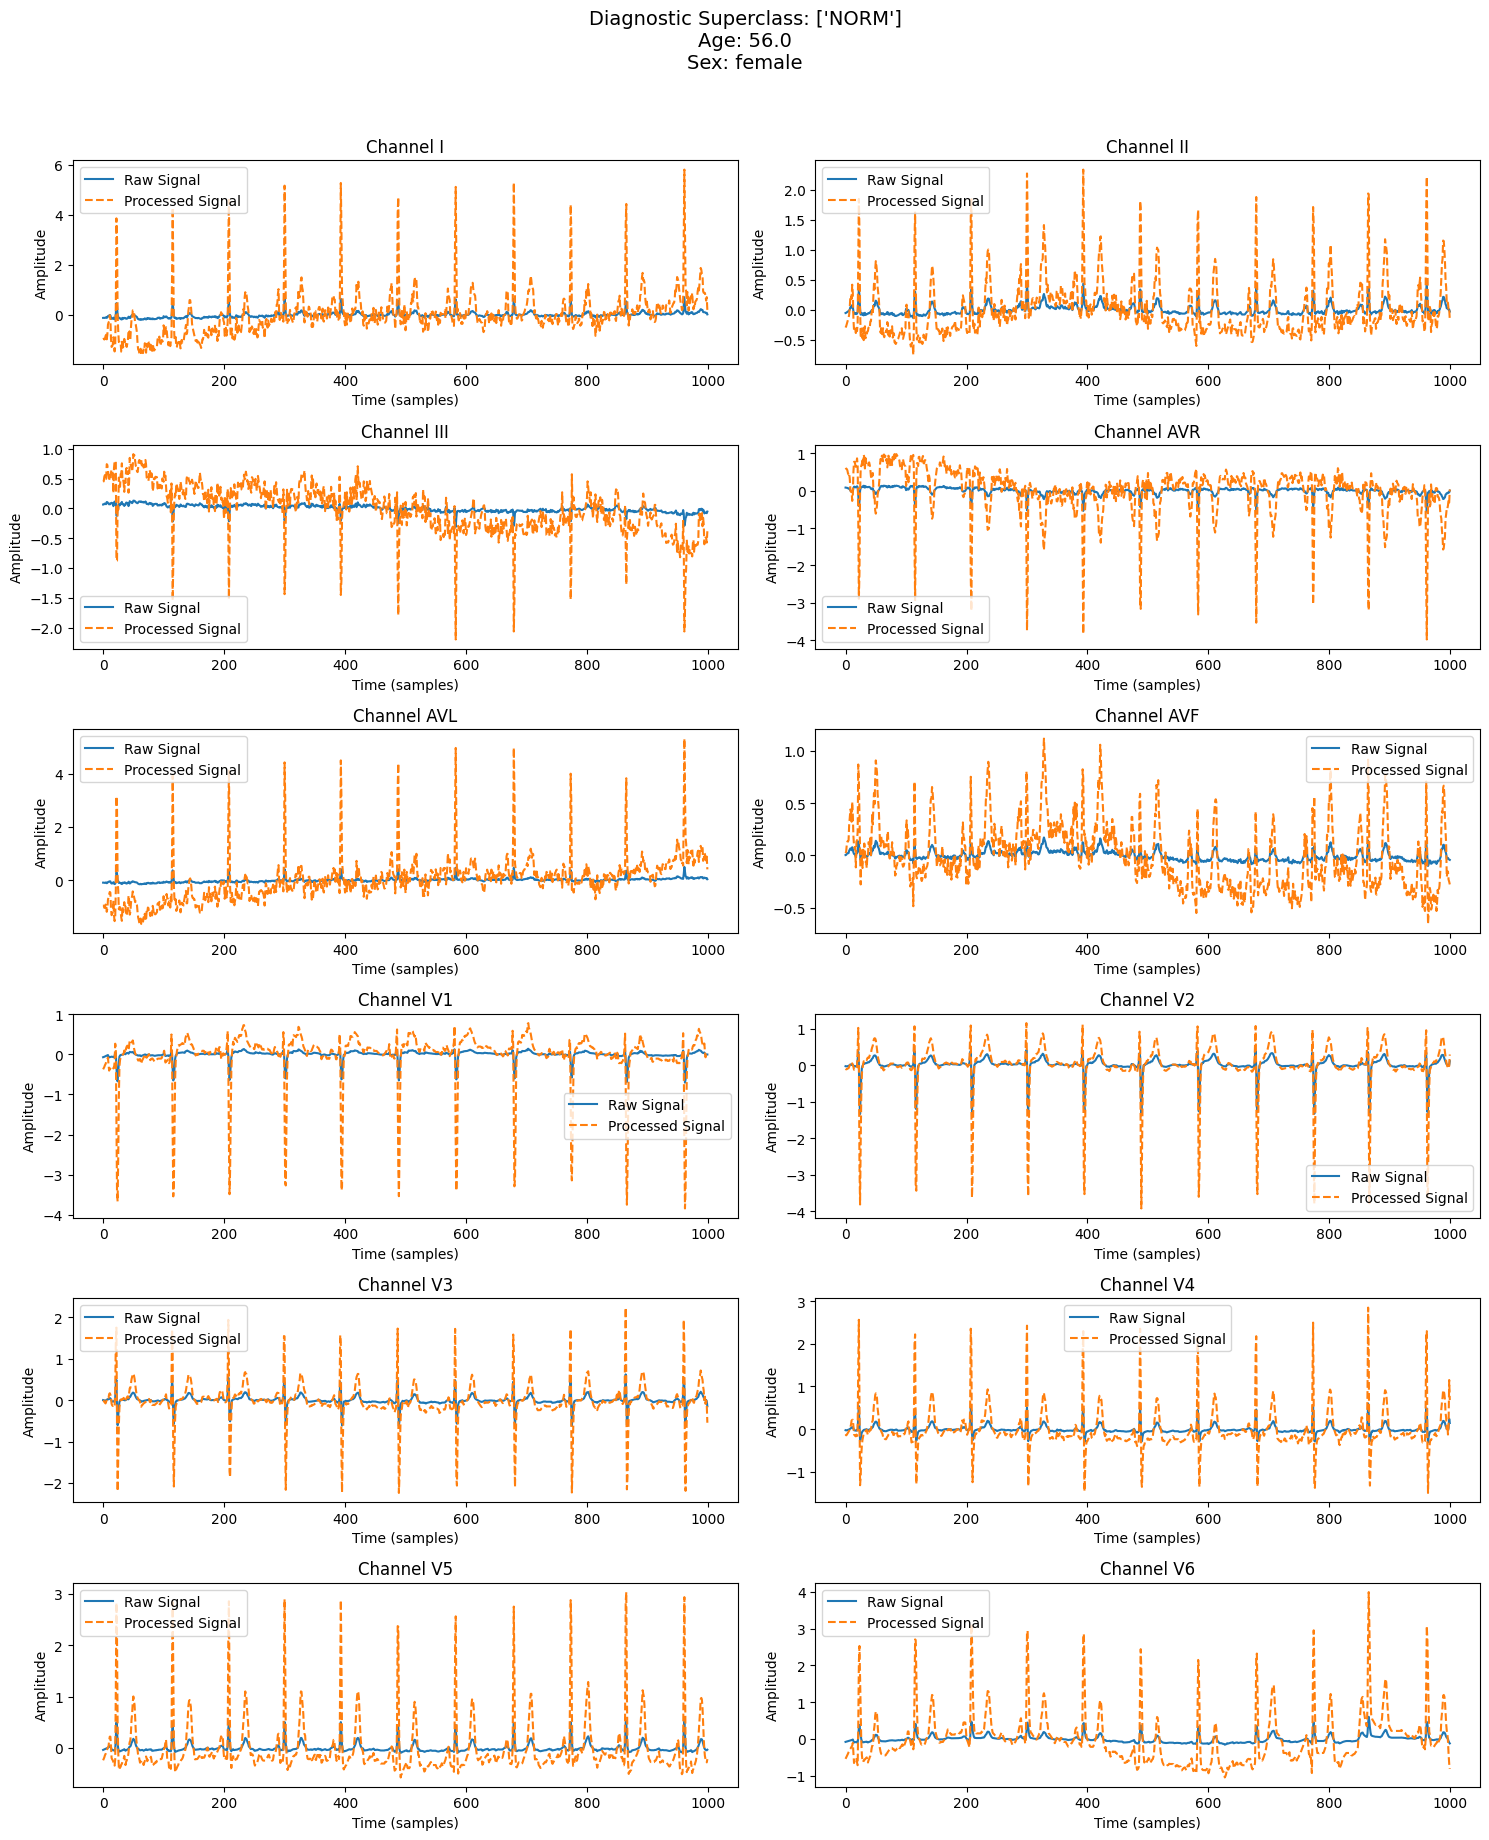

In [10]:
## For each channels
plot_raw_vs_processed_signals_grid(raw_signal, processed_signal, metadata)

**Power Spectral Density (PSD)**


/usr/local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


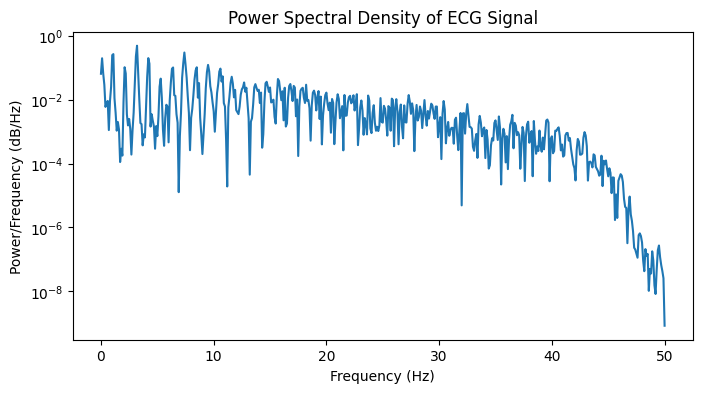

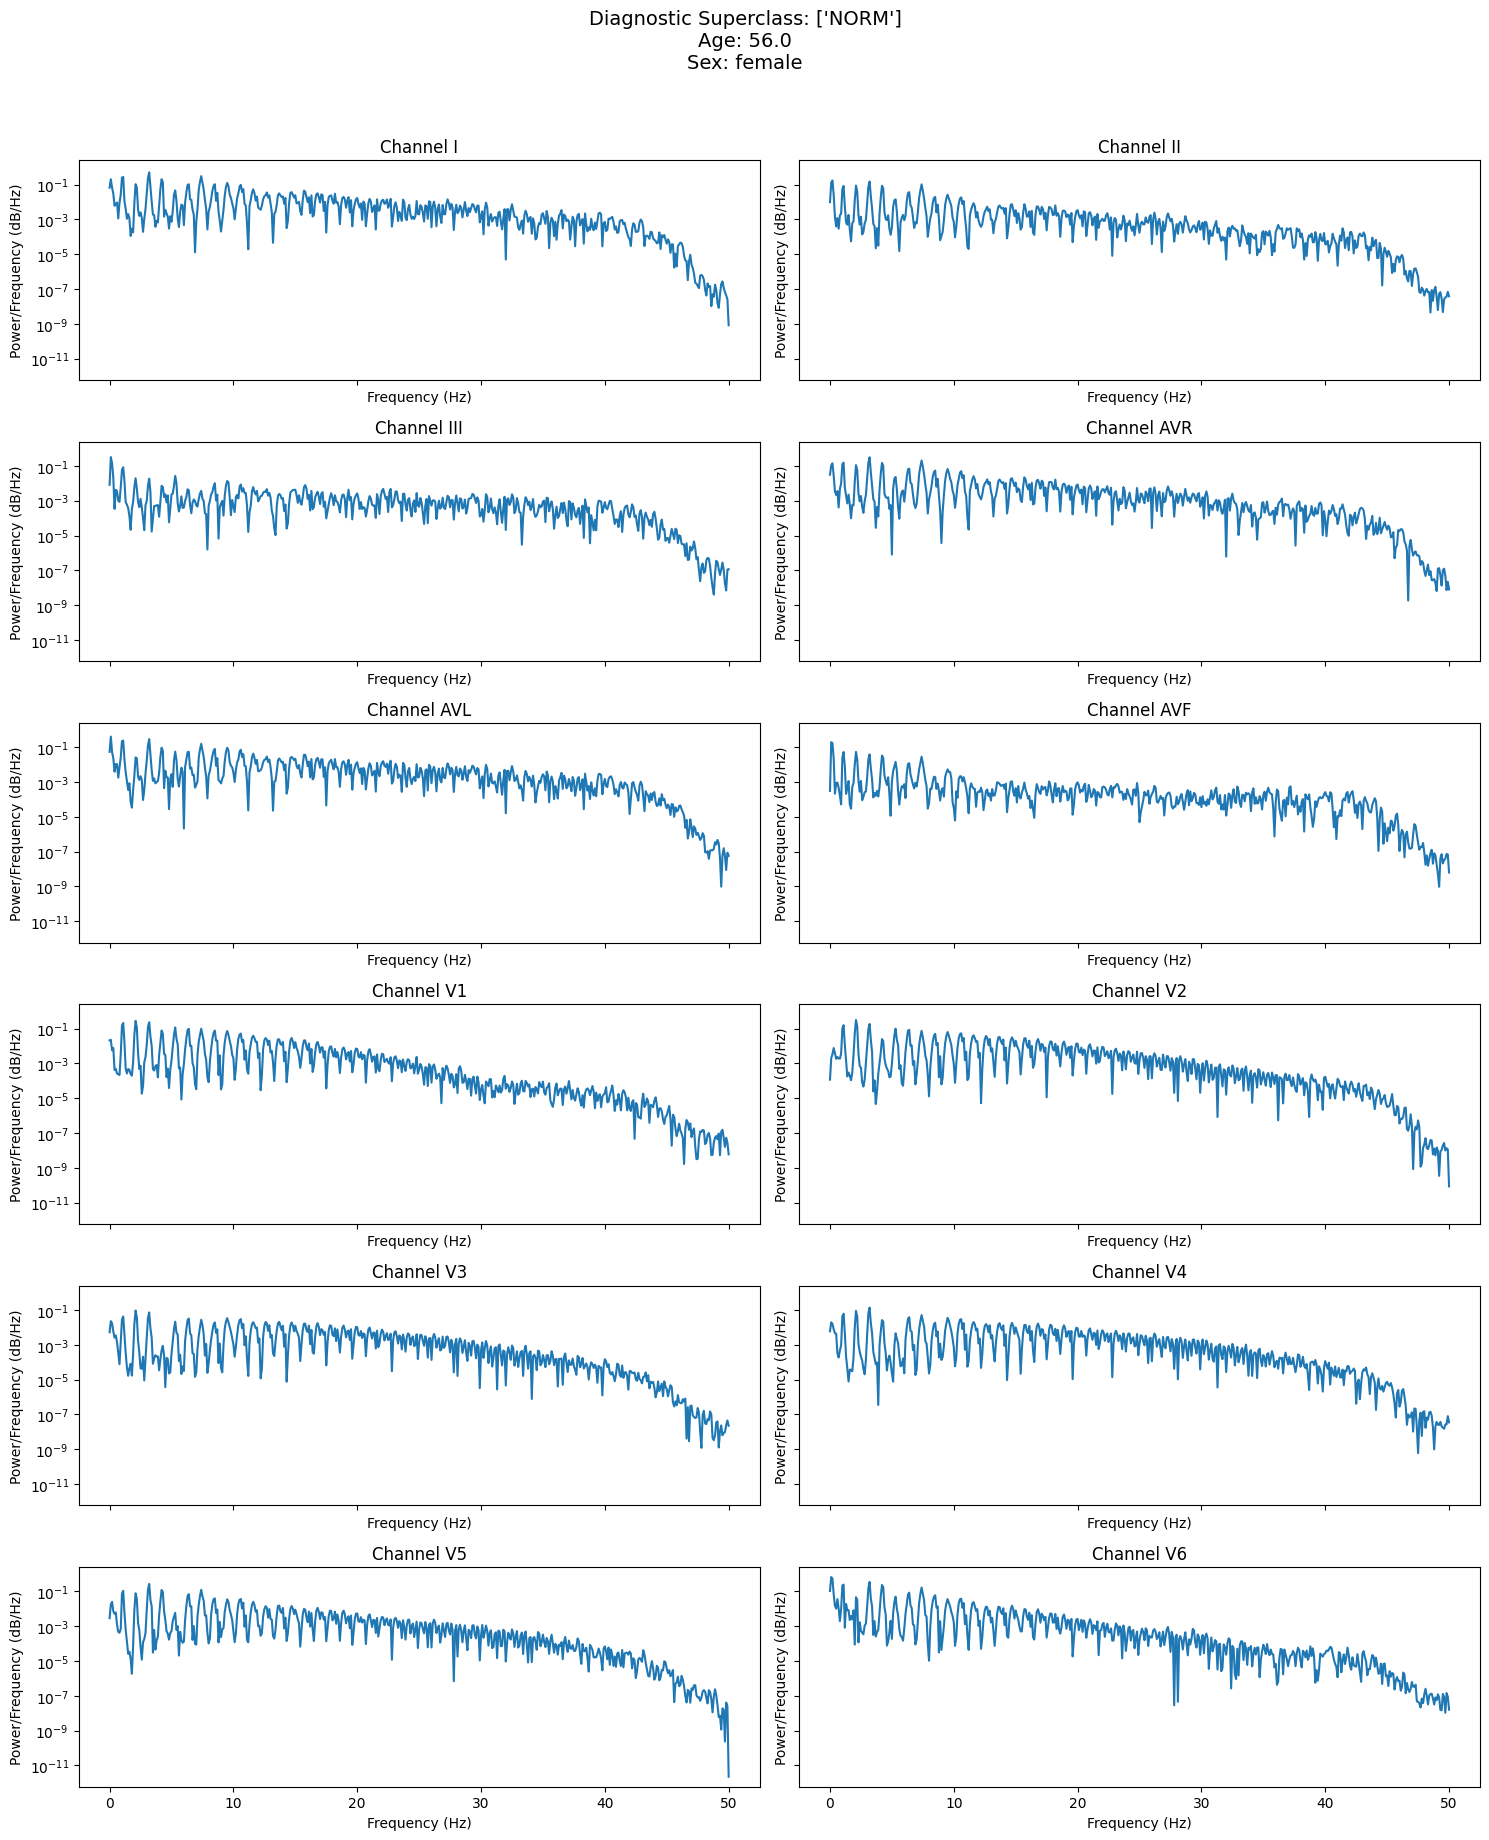

In [11]:

# Plot PSD of a processed signal
plot_psd(processed_signal[:,0], sample_rate=100)
plot_psd_multichannel(processed_signal, sample_rate=100, annotation_row= metadata)

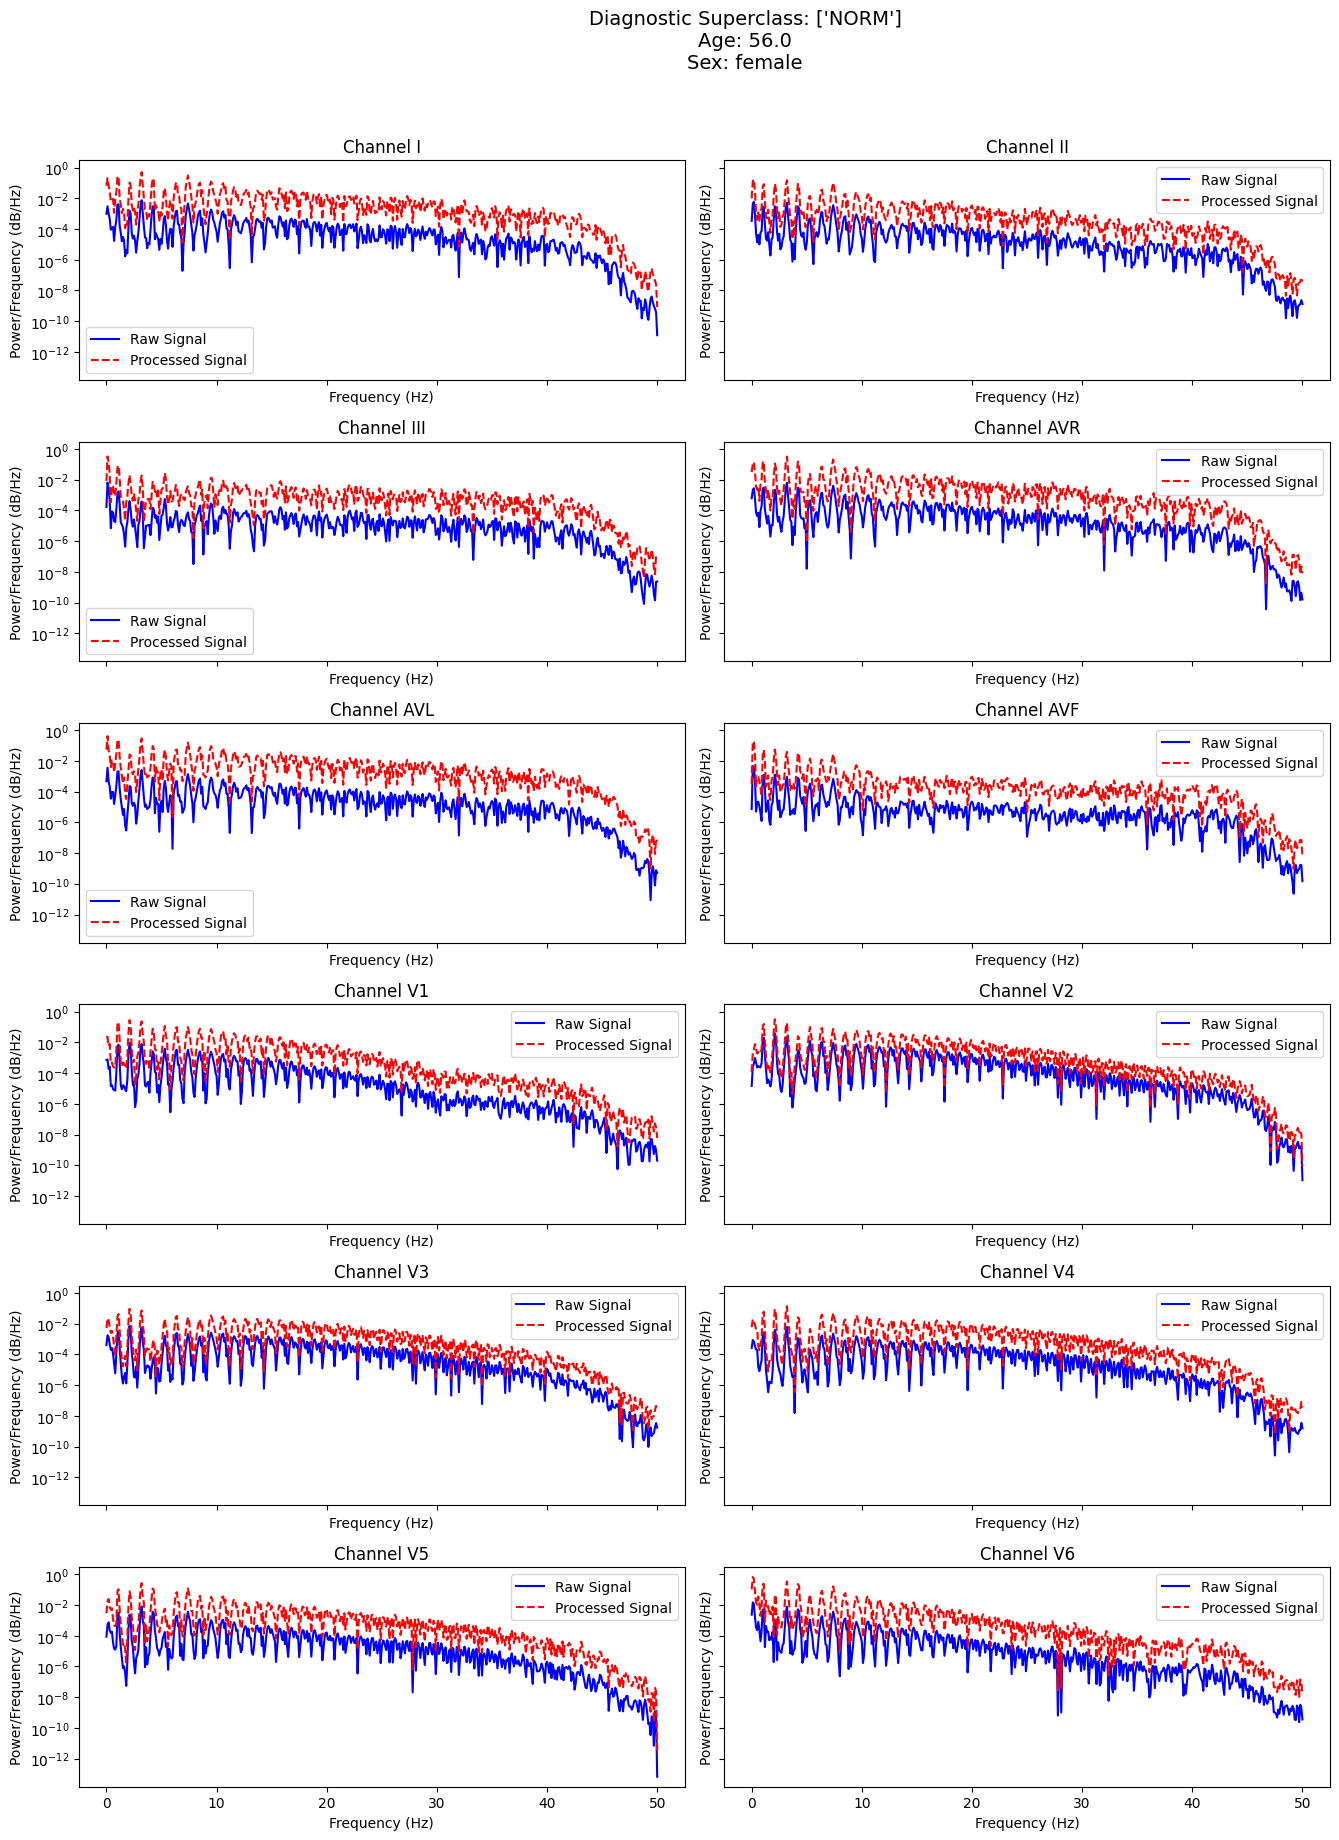

In [12]:
# Plot the comparison of PSD
plot_psd_comparison(raw_signal, processed_signal, sample_rate=100, annotation_row= metadata)

The Power Spectral Density (PSD) measures the power of a signal across different frequency components. Even if the data are preprocessed, comparing PSDs reveals that the processed data often have higher overall power or energy density, indicating enhanced signal characteristics or features preserved in the processing stage. This comparison helps in assessing the impact of preprocessing on signal quality and feature representation.

### 3.2 Data Splits/Distribution

- **`plot_amplitude_distribution`**: This function shows the distribution of signal amplitudes across a bunch of samples. It uses a histogram with a KDE plot to visualize the amplitude distribution.

- **`plot_class_distribution`** and **`plot_combined_class_distribution_relative`**: function to plot distribution of different diagnostic classes within the dataset using a count plot, and compare the relative freq among the splits.

**Distribution of signal amplitudes**


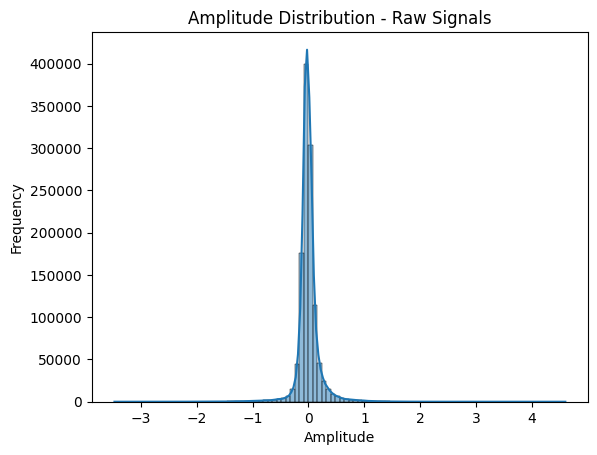

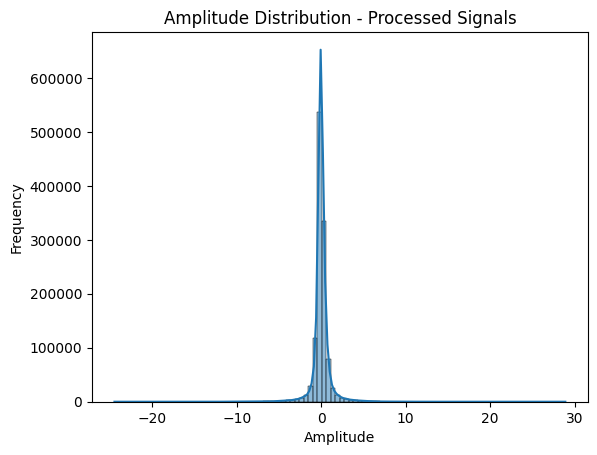

In [13]:
plot_amplitude_distribution(raw_data['ecg_signals'][:100], title='Raw Signals')

plot_amplitude_distribution(preprocessors['train'].signal_clean[:100], title='Processed Signals')


As said before, on the x-axis (amplitude) the processed signal have bigger due to scaling. 

**Distribution of classes**

2024-08-25 20:37:10,783 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-25 20:37:10,792 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


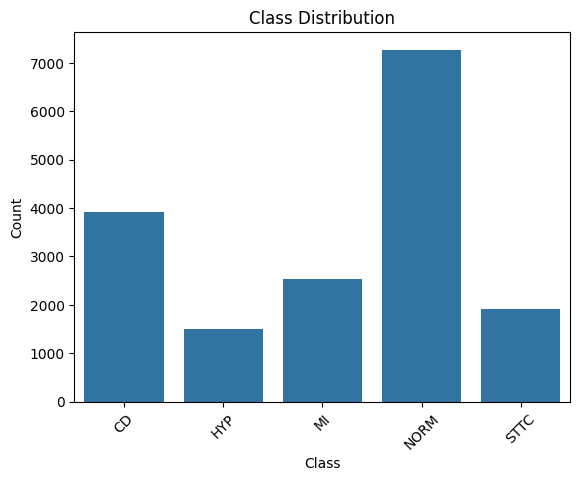

In [14]:
# Distribution among classes of trian data
labels = np.argmax(preprocessors['train'].labels_bin, axis=1)

# Plot the class distribution
plot_class_distribution(labels, classes=preprocessors['train'].labels_class)

We can see, as mentioned in the README of data, that the classes are unbalanced in the training data. This might be a bias for our ML model.

**Distribution of classes among splits**

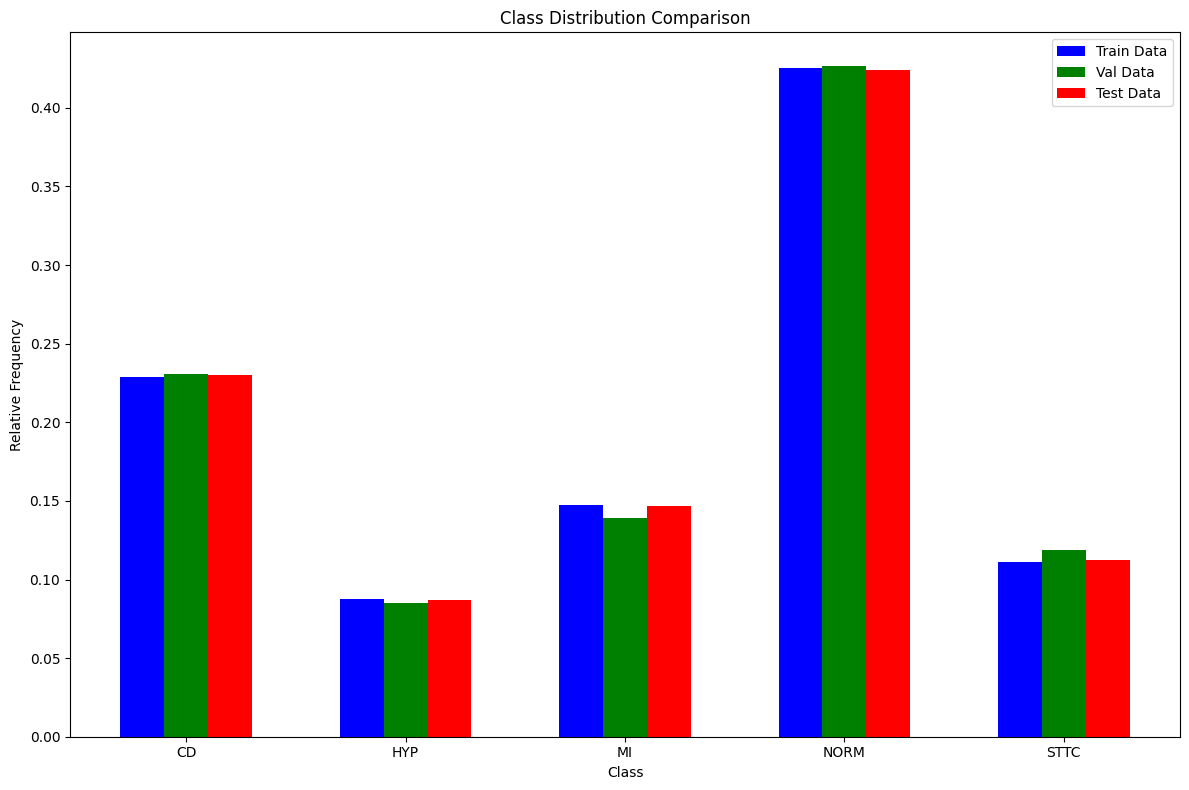

In [15]:
plot_combined_class_distribution_relative(preprocessors, classes=preprocessors['train'].labels_class)


The unbalance problem is also present in val and test set. A way to overcome this cam be to oversample or undersample the data. Or better to train a generative model to generate data for the minority classes (HYP, MI, STTC, CD)

## 4. Model Training and Validation

We will now initialize the model, set up the hyperparams, the training loop, and perform validation.

- **Model**: a simple ResNet
- **Loss**: BCEWithLogitsLoss


In [16]:
num_epochs = 30
learning_rate = 0.001
weight_decay = 1e-4
patience = 5 # early stoppy max patience

# Initialize model and hyperparameters
num_classes = data_info['num_classes']
channels = data_info['channels']
labels_class = data_info['labels_class']

model = ResNet(num_classes=num_classes, input_channels=channels, block_layers=[2, 2, 2], block_channels=[64, 128, 256], kernel_sizes=[7, 5, 3])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setup optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                        max_lr=learning_rate,
                                                        steps_per_epoch=len(dataloaders['train']),
                                                        epochs=num_epochs)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
save_path= experiment_dir.joinpath("model_checkpoint.pth")
best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_steps = patience

# History dictionary
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'learning_rate': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}


In [17]:
# Training loop
logger.info("Starting training...")
for epoch in range(num_epochs):  # Example with 2 epochs
    model.train()
    train_loss = 0
    for data, target in dataloaders['train']:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()         
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    train_loss /= len(dataloaders['train'].dataset)

    # Validation loop
    model.eval()
    val_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in dataloaders['val']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()
            all_targets.append(target.cpu())
            all_predictions.append(torch.sigmoid(output).cpu())  # Assuming binary classification

    val_loss /= len(dataloaders['val'].dataset)
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)

    # Compute metrics
    predictions = (all_predictions > 0.5).float()
    accuracy = accuracy_score(all_targets.numpy(), predictions.numpy())
    precision = precision_score(all_targets.numpy(), predictions.numpy(), average='macro')
    recall = recall_score(all_targets.numpy(), predictions.numpy(), average='macro')
    f1 = f1_score(all_targets.numpy(), predictions.numpy(), average='macro')

    # Store the metrics
    current_lr = scheduler.get_last_lr()[0]
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rate'].append(current_lr)
    history['val_accuracy'].append(accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    logger.info(f"Epoch {epoch + 1}/2, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    logger.info(f"Validation: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model and training state
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
        }, save_path)
        logger.info(f"Model checkpoint saved to {save_path}")
    else:
        early_stopping_counter += 1
        logger.info(f"\tEarly stopping counter {early_stopping_counter}/{early_stopping_steps}")
    if early_stopping_counter >= early_stopping_steps:
        logger.info(f"\tEarly stopping triggered at epoch {epoch + 1}")
        break


2024-08-25 20:37:14,998 - root - INFO - Starting training...
2024-08-25 20:37:28,695 - root - INFO - Epoch 1/2, Train Loss: 0.0034, Val Loss: 0.0028, LR: 0.000069
2024-08-25 20:37:28,697 - root - INFO - Validation: Accuracy: 0.4926, Precision: 0.7559, Recall: 0.4925, F1-Score: 0.5734
2024-08-25 20:37:28,826 - root - INFO - Model checkpoint saved to experiments/2024_08_25/20_35_57/model_checkpoint.pth
2024-08-25 20:37:40,147 - root - INFO - Epoch 2/2, Train Loss: 0.0025, Val Loss: 0.0027, LR: 0.000152
2024-08-25 20:37:40,149 - root - INFO - Validation: Accuracy: 0.5288, Precision: 0.7278, Recall: 0.6708, F1-Score: 0.6860
2024-08-25 20:37:40,299 - root - INFO - Model checkpoint saved to experiments/2024_08_25/20_35_57/model_checkpoint.pth
2024-08-25 20:37:51,630 - root - INFO - Epoch 3/2, Train Loss: 0.0023, Val Loss: 0.0024, LR: 0.000280
2024-08-25 20:37:51,631 - root - INFO - Validation: Accuracy: 0.5612, Precision: 0.7716, Recall: 0.6185, F1-Score: 0.6720
2024-08-25 20:37:51,833 - roo

## 5. Testing

In this section, we'll load the best model and evaluate it on the test set.


In [18]:
# Load the best model
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
logger.info("Starting evaluation on test set:")
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in dataloaders['test']:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_targets.append(target.cpu())
        all_predictions.append(torch.sigmoid(output).cpu())  # Assuming binary classification

all_targets = torch.cat(all_targets)
all_predictions = torch.cat(all_predictions)
predictions = (all_predictions > 0.5).float()

# Classification report
class_report = classification_report(all_targets.numpy(), predictions.numpy(), target_names=labels_class, zero_division=0)
logger.info(f"Classification Report:\n{class_report}")

# Save classification report

with open(experiment_dir.joinpath('results/test_classification_report.txt'), 'w') as f:
    f.write(class_report)

# Compute and log metrics
accuracy = accuracy_score(all_targets.numpy(), predictions.numpy())
precision = precision_score(all_targets.numpy(), predictions.numpy(), average='macro')
recall = recall_score(all_targets.numpy(), predictions.numpy(), average='macro')
f1 = f1_score(all_targets.numpy(), predictions.numpy(), average='macro')

logger.info(f"Test Accuracy: {accuracy:.3f}")
logger.info(f"Test Precision (Macro): {precision:.3f}")
logger.info(f"Test Recall (Macro): {recall:.3f}")
logger.info(f"Test F1-Score (Macro): {f1:.3f}\n")


/tmp/ipykernel_10881/4201673957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)
2024-08-25 20:40:10,488 - root - INFO - Starting evalu

## 6. Plotting Results

Finally, let's visualize the results with some plots.


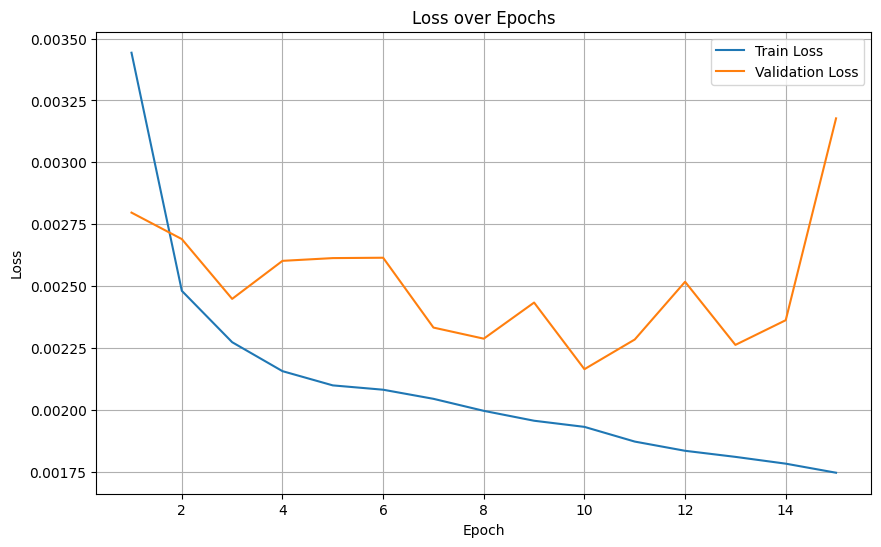

2024-08-25 20:40:11,304 - modules.visualization - INFO - Loss plot saved to loss_over_epochs.png


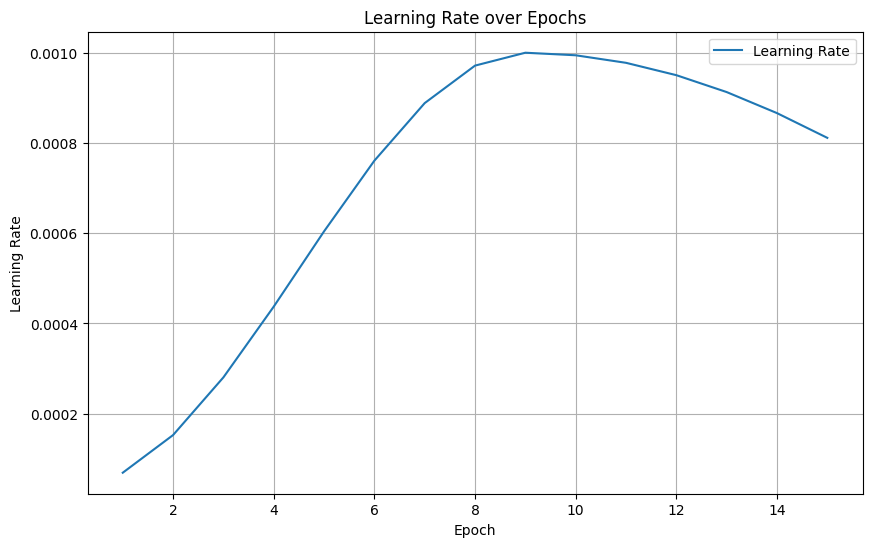

2024-08-25 20:40:11,485 - modules.visualization - INFO - Learning rate plot saved to learning_rate_over_epochs.png


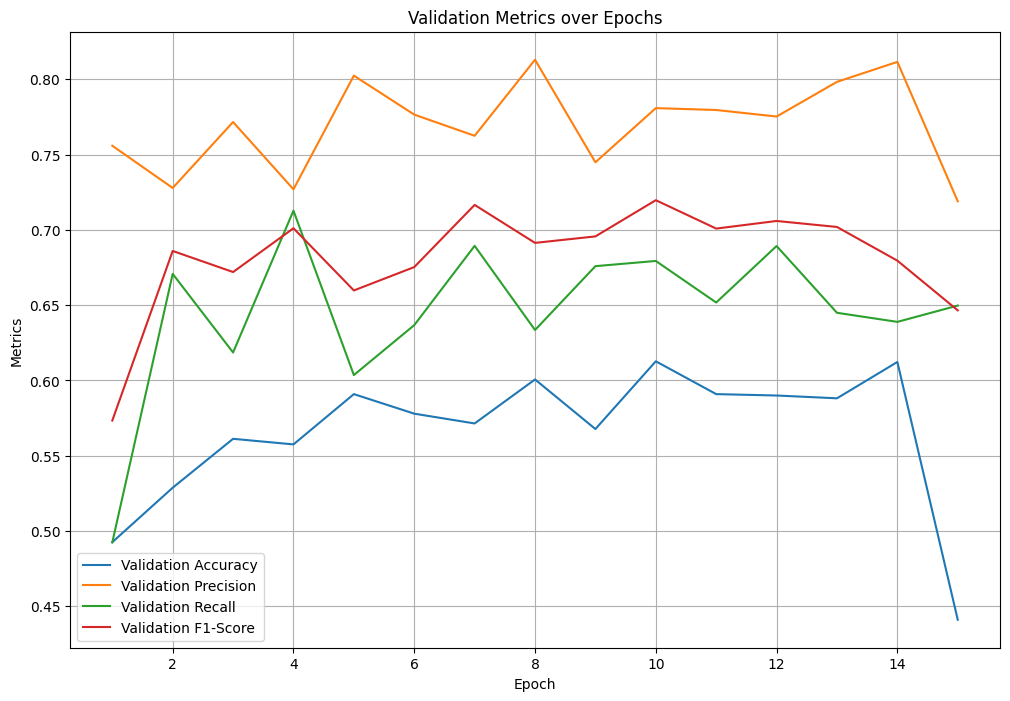

2024-08-25 20:40:11,743 - modules.visualization - INFO - Metrics plots (Accuracy, Precision, Recall, F1-Score) saved to metrics_over_epochs.png


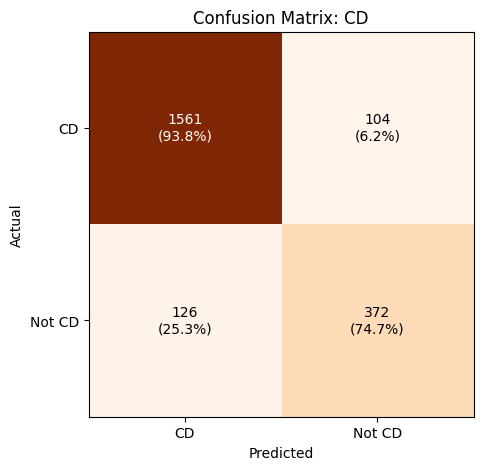

2024-08-25 20:40:11,866 - modules.visualization - INFO - Confusion matrix for class 'CD' saved at: experiments/2024_08_25/20_35_57/results/test_confusion_matrix_CD.png


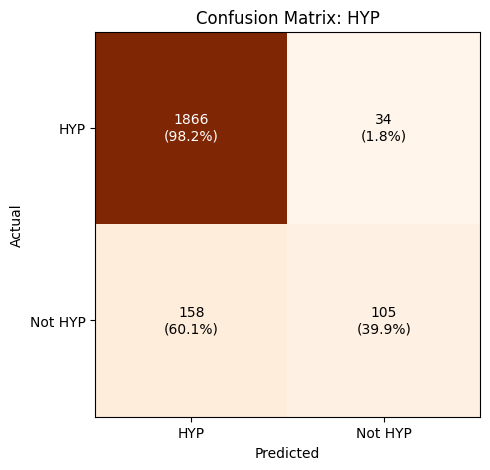

2024-08-25 20:40:11,974 - modules.visualization - INFO - Confusion matrix for class 'HYP' saved at: experiments/2024_08_25/20_35_57/results/test_confusion_matrix_HYP.png


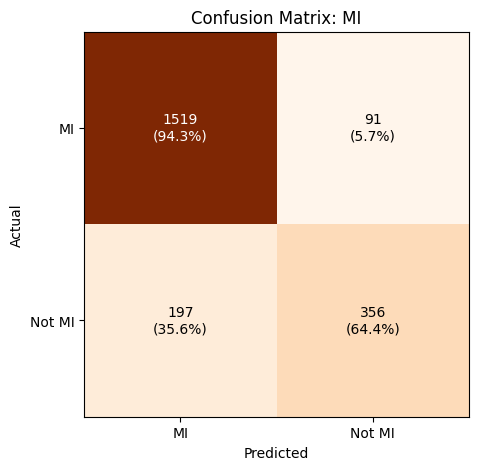

2024-08-25 20:40:12,080 - modules.visualization - INFO - Confusion matrix for class 'MI' saved at: experiments/2024_08_25/20_35_57/results/test_confusion_matrix_MI.png


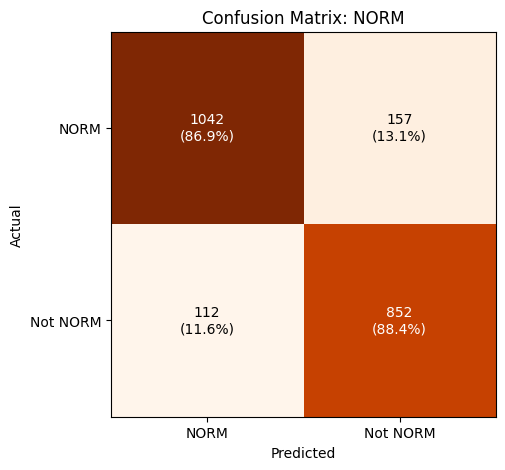

2024-08-25 20:40:12,209 - modules.visualization - INFO - Confusion matrix for class 'NORM' saved at: experiments/2024_08_25/20_35_57/results/test_confusion_matrix_NORM.png


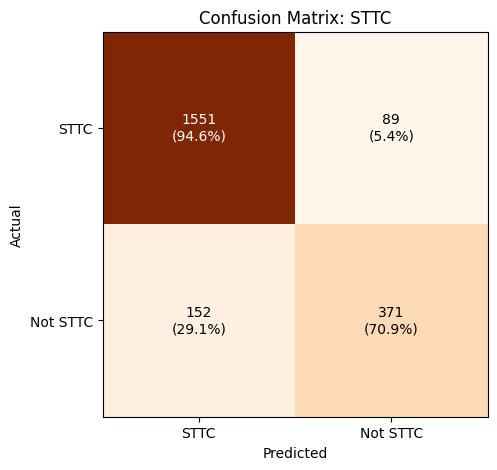

2024-08-25 20:40:12,465 - modules.visualization - INFO - Confusion matrix for class 'STTC' saved at: experiments/2024_08_25/20_35_57/results/test_confusion_matrix_STTC.png


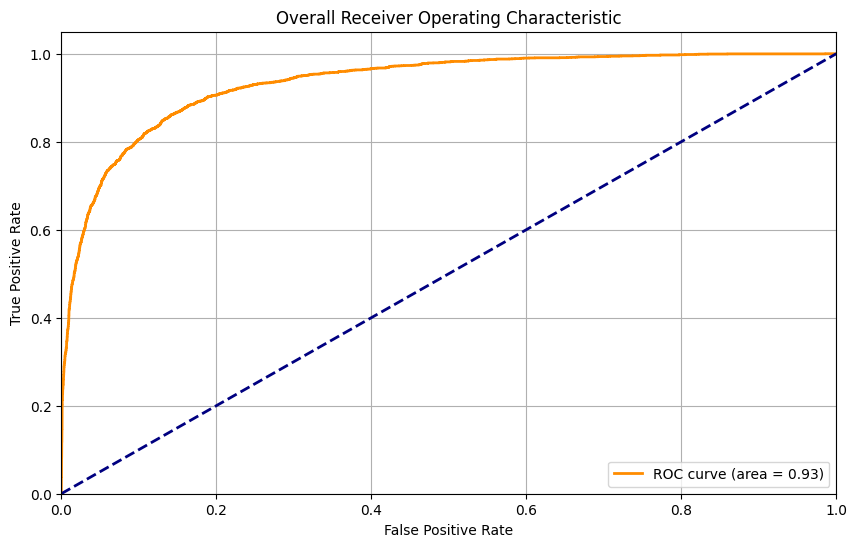

2024-08-25 20:40:12,639 - modules.visualization - INFO - ROC curve saved to roc_curve.png


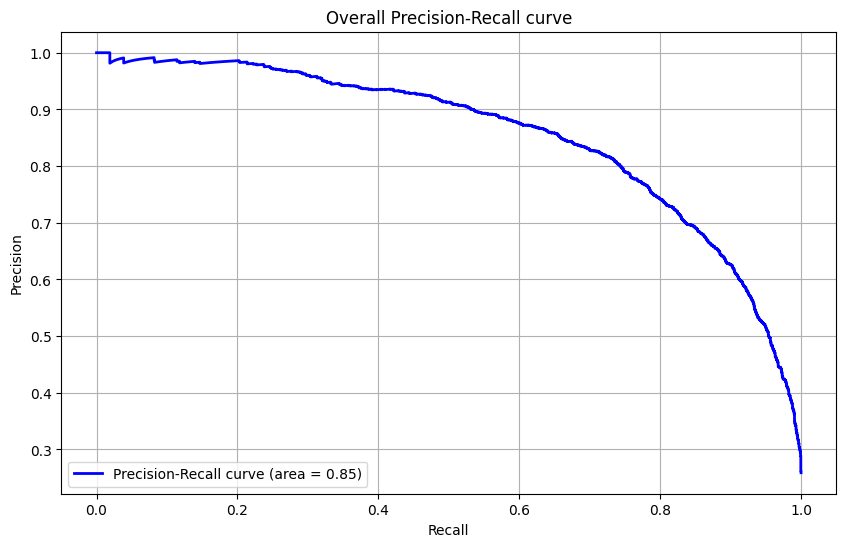

2024-08-25 20:40:12,832 - modules.visualization - INFO - Precision-Recall curve saved to precision_recall_curve.png


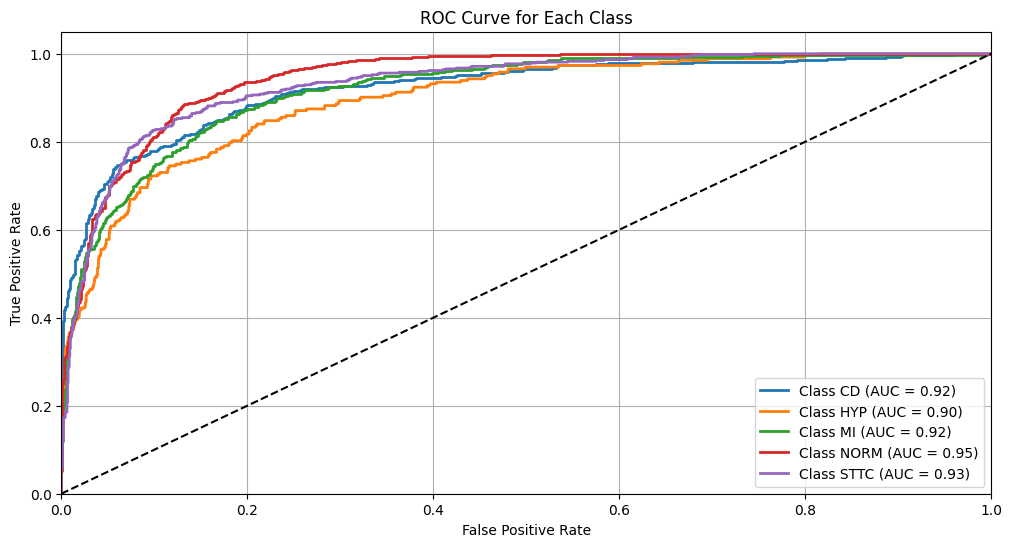

2024-08-25 20:40:13,088 - modules.visualization - INFO - ROC curve for each class saved to roc_curve_per_class.png


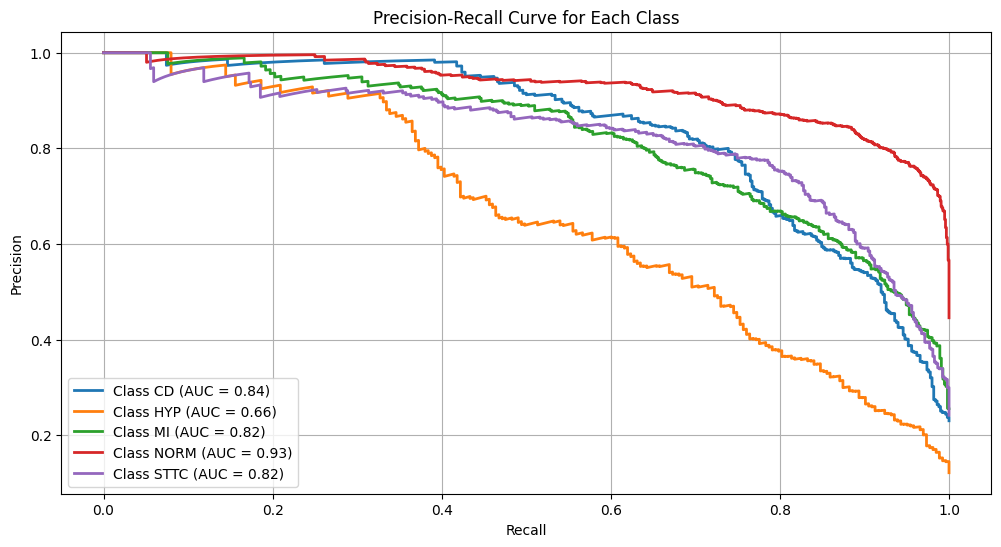

2024-08-25 20:40:13,311 - modules.visualization - INFO - Precision-Recall curve for each class saved to precision_recall_curve_per_class.png
2024-08-25 20:40:13,313 - root - INFO - Successfully plotted!



In [19]:
# Plot results
results_dir = experiment_dir.joinpath('results')
results_dir.mkdir(parents=True, exist_ok=True)

plot_metrics(history, results_dir, 'val')
plot_and_save_individual_confusion_matrices(true_labels=all_targets.numpy(), predicted_labels=predictions.numpy(), class_names=labels_class, save_dir=results_dir, data_type='test')
plot_roc_curve(all_targets, all_predictions, results_dir, 'test')
plot_precision_recall_curve(all_targets, all_predictions, results_dir, 'test')
plot_roc_curve_per_class(all_targets, all_predictions, labels_class, results_dir, 'test')
plot_precision_recall_curve_per_class(all_targets, all_predictions, labels_class, results_dir, 'test')

logger.info("Successfully plotted!\n")


## 7.Explainability of results with Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) generates visual explanations by using the gradients of the target class flowing into the final convolutional layer to produce a heatmap. This heatmap highlights the regions in the input that are most important for the model's decision, helping to interpret which parts of the input are driving the predictions. I think this is a useful functionality that can help engineers but also medical doctor to see whether the model is reasoning like a cardiologist.

**Define GradCAM**

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx):
        output = self.model(input_image)
        self.model.zero_grad() # block grad
        score = output[:, class_idx]
        score.backward(retain_graph=True) # get score
        gradients = self.gradients
        activation = self.activation
        pooled_gradients = torch.mean(gradients, dim=[0, 2]) # Pool the gradients across the spatial dimensions

        # Weight the channel with grad
        for i in range(activation.shape[1]):
            activation[:, i, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = heatmap / torch.max(heatmap)
        return heatmap.detach().cpu().numpy()


In [21]:
# Useful function for plotting
def plot_signals_with_gradcam(ecg_signals: np.ndarray, gradcam_heatmaps: np.ndarray, predicted_class_name: str, actual_class_name: str):
    """Plot ECG signals with Grad-CAM heatmaps for each channel."""
    CHANNELS_NAME = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    num_channels = ecg_signals.shape[1]
    num_rows = num_channels
    num_cols = 1 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows), sharex=True)

    if num_channels == 1: 
        axes = [axes]

    for i in range(num_channels):
        # Plot ECG signal
        axes[i].plot(ecg_signals[:, i], label='ECG Signal', color='blue')
        axes[i].set_ylim(np.min(ecg_signals[:, i]), np.max(ecg_signals[:, i]))  # Set y-axis to ECG signal's amplitude range

        # Overlay Grad-CAM heatmap resized to match the ECG signal
        heatmap_resized = np.interp(gradcam_heatmaps[i], (gradcam_heatmaps[i].min(), gradcam_heatmaps[i].max()), (0, 1))
        axes[i].imshow(heatmap_resized[None, :], cmap='jet', alpha=0.5, aspect='auto',
                       extent=(0, len(ecg_signals[:, i]), np.min(ecg_signals[:, i]), np.max(ecg_signals[:, i])))

        # Set titles and labels
        axes[i].set_title(f'Channel {CHANNELS_NAME[i]} - Grad-CAM Heatmap\nPredicted: {predicted_class_name}, Actual: {actual_class_name}')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('Amplitude')
        axes[i].legend()

    plt.tight_layout()
    plt.show()


**Model structure**

In [24]:
import torch
from modules.networks import ResNet

def load_model_for_inference(checkpoint_path):
    # Must match the model network
    num_classes = 5
    input_channels = 12
    block_layers = [2, 2, 2]  
    block_channels = [64, 128, 256]  
    kernel_sizes = [7, 5, 3]
    
    model = ResNet(num_classes=num_classes, input_channels=input_channels, block_layers=block_layers,
                    block_channels=block_channels, kernel_sizes=kernel_sizes)
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model

In [22]:
load = False # use the same as training
if load:
    model_path = ''
    model = load_model_for_inference(model_path)
model = model.to('cpu') 
model

ResNet(
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(12, 64, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

**Plot the Grad-CAM for the signal**

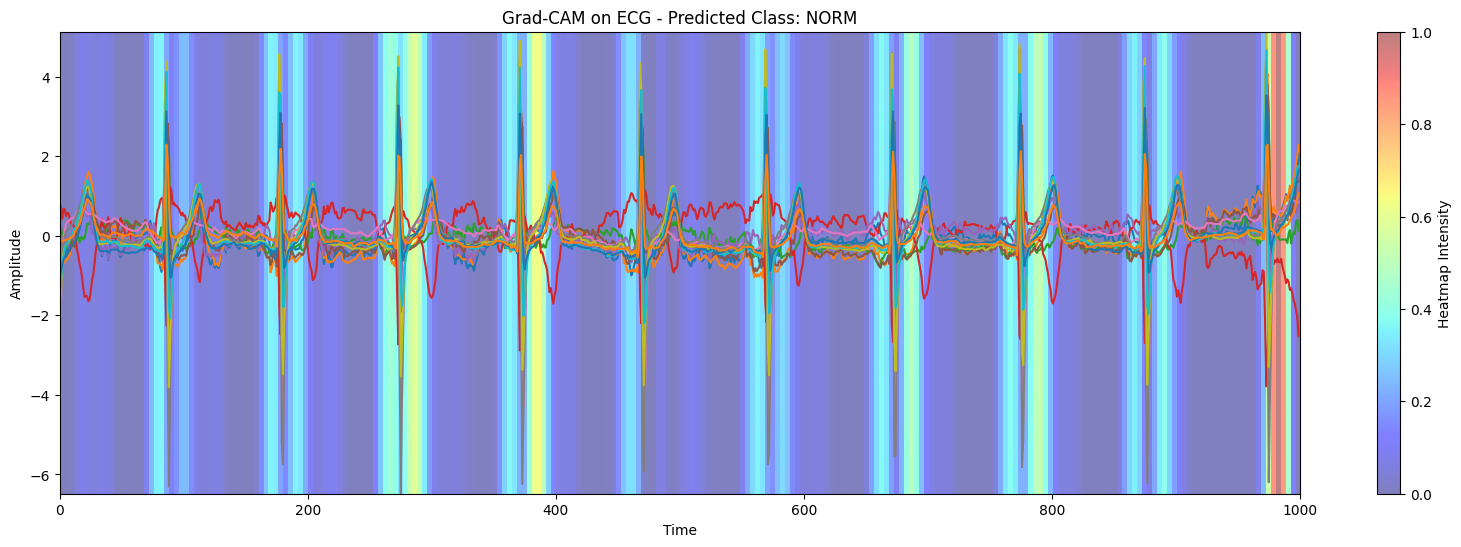

In [26]:
# Identify the target layer
target_layer = model.layer3[1].conv2  # Get last convolutional layer in layer3

# Instantiate the GradCAM object
gradcam = GradCAM1D(model, target_layer)

# get a sample
images, labels = next(iter(dataloaders['test']))
image = images[0:1] 
label = labels[0]    

# Grad-CAM 
output = model(image)
predicted_class_idx = output.argmax(dim=1).item()
heatmap = gradcam.generate(image, predicted_class_idx)
predicted_class_name = labels_class[predicted_class_idx]
# Plot
ecg_signal = image[0].detach().cpu().numpy().squeeze()
plt.figure(figsize=(20, 6))
plt.plot(ecg_signal, label='ECG Signal')
# Overlay heatmap
heatmap_resized = np.interp(heatmap, (heatmap.min(), heatmap.max()), (0, 1)) 
plt.imshow(heatmap_resized[None, :], cmap='jet', alpha=0.5, aspect='auto', extent=(0, len(ecg_signal), np.min(ecg_signal), np.max(ecg_signal)))

plt.title(f"Grad-CAM on ECG - Predicted Class: {predicted_class_name}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.colorbar(label='Heatmap Intensity')
plt.show()


Now, we can show this to cardiologits and see whether the ML model is focusing on the right parts of the signal.

**Plot the Grad-CAM channel-wise**

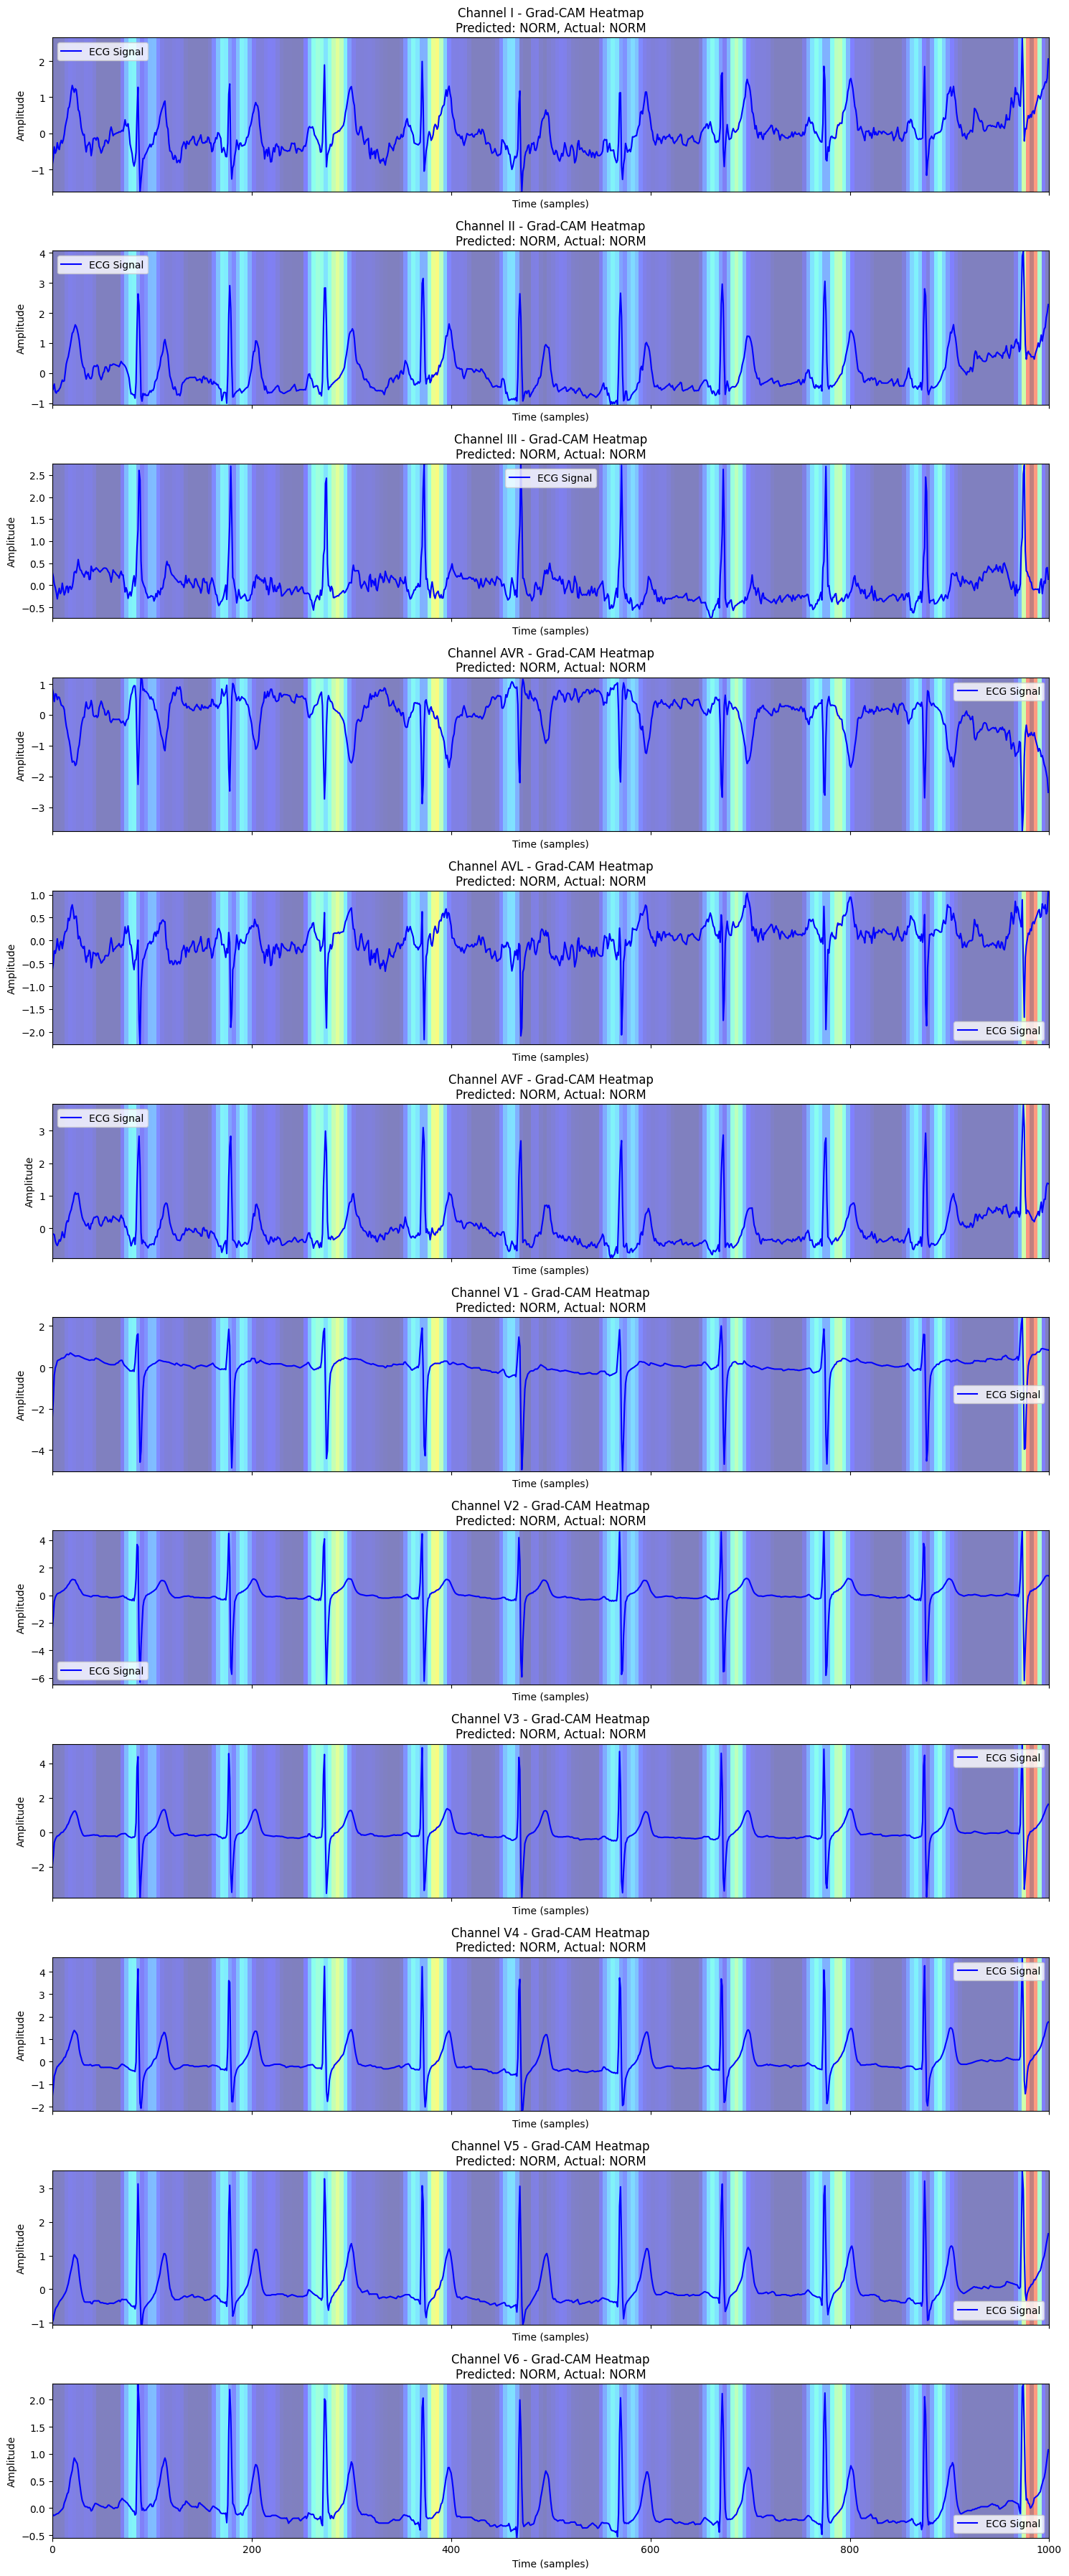

In [27]:
# Identify the target layer
target_layer = model.layer3[1].conv2  # Last convolutional layer in layer3
gradcam = GradCAM1D(model, target_layer)

# Compute Grad-CAM for the first sample
output = model(image)
predicted_class_idx = output.argmax(dim=1).item() 
actual_class_idx = label.argmax().item()  
labels_class = np.array(['CD', 'HYP', 'MI', 'NORM', 'STTC'])
predicted_class_name = labels_class[predicted_class_idx]
actual_class_name = labels_class[actual_class_idx]

gradcam_heatmaps = []
for i in range(image.shape[2]):  # Iterate over channels
    heatmap = gradcam.generate(image, predicted_class_idx)
    gradcam_heatmaps.append(heatmap)

gradcam_heatmaps = np.array(gradcam_heatmaps)
# Plot signals with Grad-CAM
ecg_signals = image[0].detach().cpu().numpy()#
plot_signals_with_gradcam(ecg_signals, gradcam_heatmaps, predicted_class_name, actual_class_name)

# Conclusion

This notebook outlined the entire process from data loading to model training and evaluation, ending with visualizations of the results. 

**Insights and Learnings**

By approching the task by implementing from scracth most of the funtionalities of this project I gained a deeper understanding of the intricacies of cardiac signals and their significance in medical diagnostics. The experience was both educational and rewarding (for example by applying the GradCAM to signal data). I am enthusiastic about the potential for future advancements in this field and eager to build upon these insights and experiences. 

**Future works**:
- Experiment tracking with the cloud
- Adding a variety of model architectures
- Implementing test (pyunit, pytest) for continuous integration
- Developing a more comprehensive benchmarking setup for comparing multiple models
- Including function documentation as libraries with descriptions, arguments, and return values
